### Creación del algoritmo genético

In [219]:
# Importamos librerías
import json
import random

In [220]:
# Definimos los parámetros para el algoritmo genético
POPULATION_SIZE = 150
MUTATION_RATE = 0.1
GENERATIONS = 10000

Para cada helado:
- 5 Sabores
- 3 Bases
- 1 Edulcorante
- 3 Topings

In [221]:
try:
    # Cargamos los datos de los ingredientes del archivo json
    with open("ingredientes.json", "r") as archivo:
        ingredientes = json.load(archivo)
except FileNotFoundError:
    raise ValueError("No se encontró el archivo especificado, asegurate de que esté dentro de la misma carpeta")

#### Definición de funciones

In [222]:
# Definimos una función para crear una población del tamaño especificado con individuos (helados) de ingredientes aleatorios
def crear_poblacion(population_size):
    poblacion = []
    for _ in range(population_size):
        helado = {
            'sabores': random.sample(list(ingredientes["sabores_helado"].keys()), 5),
            'bases': random.sample(list(ingredientes["bases_helado"].keys()), 3),
            'edulcorante': random.choice(list(ingredientes["edulcorantes_helados"].keys())),
            'toppings': random.sample(list(ingredientes["toppings_siropes_helados"].keys()), 3)
        }
        poblacion.append(helado)
    return poblacion

In [223]:
# Definimos una función fitness para evaluar los helados según la puntuación que den en la suma de su sabor, textura y novedad
def fitness(helado):
    individuo = []
    individuo.extend(helado["sabores"])
    individuo.extend(helado["bases"])
    individuo.append(helado["edulcorante"])
    individuo.extend(helado["toppings"])

    sabores = []
    textura = []
    novedad = []

    for clave in ingredientes.keys():
        for ingrediente in individuo:
            if ingrediente in ingredientes[clave]:
                sabores.append(ingredientes[clave][ingrediente]["Sabor"])
                textura.append(ingredientes[clave][ingrediente]["Textura"])
                novedad.append(ingredientes[clave][ingrediente]["Novedad"])

    sabor_total = sum(sabores)
    textura_total = sum(textura)
    novedad_total = sum(novedad)

    return sabor_total + textura_total + novedad_total # El máximo teórico es de 12(ingredientes por helado) * 30(máximo sabor, textura y novedad) = 360

In [224]:
# Definimos una función de selección que ordena una población dada en orden descendente según el fitness de cada helado
def selection(poblacion):
    poblacion_ordenada = sorted(poblacion, key=lambda x: fitness(x), reverse=True)

    return poblacion_ordenada[:POPULATION_SIZE+1] # Esta limitación de tamaño es necesaria ya que al crear nuevas generaciones las estoy rebasando la población existente para luego acotarla con un selection

In [225]:
# Definimos la función de mutación
def mutation(individuo):
    # Asocio los atributos del helado con los atributos de la tabla de ingredientes del archivo json
    atributos = [('sabores', 'sabores_helado'), ('bases', 'bases_helado'), ('edulcorante', 'edulcorantes_helados'), ('toppings', 'toppings_siropes_helados')]

    if random.random() < MUTATION_RATE: # Si se cumple la probabilidad
        atributo_mutar = random.choice(atributos) # Elige un atributo aleatorio para mutar del helado

        if atributo_mutar[0] != 'edulcorante': # El edulcorante no muta ya que al ser un sólo ingrediente de esta categoría y al estar intentando maximizar sus características, la propia selección se encarga de elegir el mejor

            ingrediente = random.choice(individuo[atributo_mutar[0]]) # Elige un ingrediente aleatorio del helado para cambiar
            ingrediente_mutado = random.choice(list(set(ingredientes[atributo_mutar[1]]) - set(individuo[atributo_mutar[0]]))) # Elige un ingrediente, no contenido ya en el helado, aleatorio de la misma característica que el ingrediente a cambiar para reemplazarlo

            individuo[atributo_mutar[0]] = [ingrediente_mutado if sabor == ingrediente else sabor for sabor in individuo[atributo_mutar[0]]] # Reemplaza el ingrediente por el ingrediente mutado

    return individuo

In [226]:
# Definimos una función de cruzamiento que crea un helado("hijo") que herede de dos helados("padres") ingredientes de estos de forma aleatoria
def crossover(parent1, parent2):
    child = {
        'sabores': random.sample(list(set(parent1['sabores']).union(set(parent2['sabores']))), 5),
        'bases': random.sample(list(set(parent1['bases']).union(set(parent2['bases']))), 3),
        'edulcorante': random.choice([parent1['edulcorante'], parent2['edulcorante']]),
        'toppings': random.sample(list(set(parent1['toppings']).union(set(parent2['toppings']))), 3)
    }
    return child

In [227]:
# Definimos la función de algoritmo genético
def genetic_algorithm(population_size=POPULATION_SIZE, mutation_rate=MUTATION_RATE, generations=GENERATIONS):
    poblacion = crear_poblacion(population_size) # Creamos una población inicial

    for _ in range(generations): # Creamos nuevas generaciones y modificamos la población
        poblacion = selection(poblacion)
        nueva_generacion = []

        for _ in range(population_size): # Cruzamos ejemplares aleatorios de la población para dar paso a nuevas generaciones
            padre1, padre2 = random.choices(poblacion, k=2)
            hijo = crossover(padre1, padre2)
            nueva_generacion.append(hijo)

        poblacion = poblacion + nueva_generacion # Rebasamos la población existente con la nueva generación para luego acotarlas al tamaño de la población deseado en la siguiente iteración del bucle
        poblacion = [mutation(helado) for helado in poblacion] # Iteramos la lista de la población con la función mutation para que muten los individuos que caigan dentro de la probabilidad de mutación

    mejor_individuo = max(poblacion, key=lambda x: fitness(x))

    return mejor_individuo, fitness(mejor_individuo)

### Ajuste de hiperparámetros para el algoritmo

En vez de aumentar muchos los hiperparámetros, aumentando a su vez el coste computacional, para obtener una respuesta lo más determinista y máxima posible siempre que lo ejecute, voy a ajustar los hiperparámetros para que me de una respuesta rápida muy buena.

In [228]:
import time # Importamos la librería time para calcular el tiempo de ejecución con los parámetros originales
import numpy as np

In [229]:
t0 = time.time()
print(genetic_algorithm(POPULATION_SIZE))
tf = time.time()

print(f"El algoritmo ha tardado: {round(tf-t0, 2)}s en ejecutarse.")  # Inicialmente está tardando 39,56s en ejecutarse.

KeyboardInterrupt: 

Con los datos iniciales que le he puesto para los hiperparámetros tarda 39,56 segundos y me da siempre un fitness, que es el máximo, de 299,44.

In [230]:
# Probamos con distintos parámetros hasta llegar al siguiente resultado aceptable:
POPULATION_SIZE = 150
MUTATION_RATE = 0.1
GENERATIONS = 100

Le he reducido el número de generaciones de 10000 a 100. Ahora ejecutamos el siguiente código para comprobar la media de cuánto tarda en ejecturse y si el fitness es aceptable.

In [231]:
tiempos = []
fitness_max = []
for _ in range(20):
    t0 = time.time()
    fitness_max.append(genetic_algorithm(population_size=POPULATION_SIZE, generations=100)[1])
    tf = time.time()
    tiempos.append(round(tf-t0, 2))

print(f"La media de tiempo de ejecución ha sido de: {np.mean(tiempos)}s en ejecutarse.")
print(f"El fitness máximo ha sido de: {np.max(fitness_max)}, el más bajo de: {np.min(fitness_max)} y el fitness promedio de: {np.average(fitness_max)}.")

La media de tiempo de ejecución ha sido de: 0.40549999999999997s en ejecutarse.
El fitness máximo ha sido de: 299.44, el más bajo de: 299.35 y el fitness promedio de: 299.4309999999999.


Como podemos apreciar, el fitness que nos está dando es el máximo y en la peor situación se acerca muchísimo a este. Por lo que con un tiempo medio de ejecución de 0,43 segundos, doy por concluido el proceso de ajustes del hiperparámetro.

### Estudio gráfico de los ingredientes

### Graficando el funcionamiento del algoritmo genético

In [232]:
import matplotlib.pyplot as plt
import numpy as np

In [237]:
# Definimos la función de algoritmo genético
def genetic_algorithm(population_size=POPULATION_SIZE, mutation_rate=MUTATION_RATE, generations=GENERATIONS, verbose=False):
    max_fitness_values = []
    min_fitness_values = []

    poblacion = crear_poblacion(population_size) # Creamos una población inicial

    for _ in range(generations): # Creamos nuevas generaciones y modificamos la población
        poblacion = selection(poblacion)
        nueva_generacion = []

        for _ in range(population_size): # Cruzamos ejemplares aleatorios de la población para dar paso a nuevas generaciones
            padre1, padre2 = random.choices(poblacion, k=2)
            hijo = crossover(padre1, padre2)
            nueva_generacion.append(hijo)

        poblacion = poblacion + nueva_generacion # Rebasamos la población existente con la nueva generación para luego acotarlas al tamaño de la población deseado en la siguiente iteración del bucle
        poblacion = [mutation(helado) for helado in poblacion] # Iteramos la lista de la población con la función mutation para que muten los individuos que caigan dentro de la probabilidad de mutación
        
        mejor_individuo = max(poblacion, key=lambda x: fitness(x))
        peor_individuo = min(poblacion, key=lambda x: fitness(x))

        max_fitness_values.append(fitness(mejor_individuo))
        min_fitness_values.append(fitness(peor_individuo))

    mejor_individuo = max(poblacion, key=lambda x: fitness(x))

    plt.plot(np.arange(0, len(max_fitness_values)), max_fitness_values, color="orange", label="Fitness máximo")
    plt.title("Fitness máximo y mínimo de cada generación generación", fontdict={'fontsize': 14})
    plt.xlabel("Nº de Generaciones")
    plt.ylabel("Valor del Fitness")
    plt.plot(min_fitness_values, color="turquoise", label="Fitness mínimo")
    plt.legend()
    plt.grid(visible=True, which="both")
    plt.minorticks_on()
    plt.show()

    return mejor_individuo, fitness(mejor_individuo)

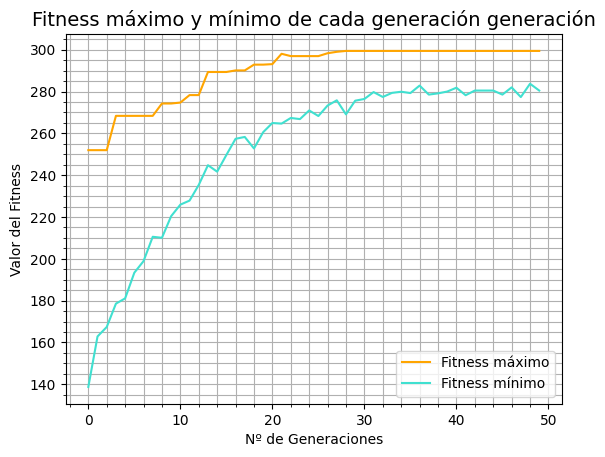

({'sabores': ['Almendra', 'Yogur', 'Dulce de membrillo', 'Naranja x', 'Sandía'], 'bases': ['Yogur', 'Leche de almendras', 'Fruta'], 'edulcorante': 'Maltitol', 'toppings': ['Pepitas de chocolate', 'Trozos de oreo', 'Salsa de mango']}, 299.44)


In [239]:
print(genetic_algorithm(population_size=POPULATION_SIZE, generations=50))

Viendo de manera visual cuál es la evolución del individuo máximo y mínimo de cada población, podemos observar como con cada generación se van incrementando hasta convergir en torno a la generación 25, como es propio de nuestro algoritmo de maximización. Al converger siempre antes de la generación número 30, podemos decidir como ajuste correcto del hiperparámetro que el algoritmo se ejecute siempre para 30 generaciones.

In [235]:
# Definimos la función de algoritmo genético
def genetic_algorithm(population_size=POPULATION_SIZE, mutation_rate=MUTATION_RATE, generations=GENERATIONS, verbose=False):
    avg_fitness_values = []

    poblacion = crear_poblacion(population_size) # Creamos una población inicial

    for _ in range(generations): # Creamos nuevas generaciones y modificamos la población
        promedio_generacion = []
        poblacion = selection(poblacion)
        nueva_generacion = []

        for _ in range(population_size): # Cruzamos ejemplares aleatorios de la población para dar paso a nuevas generaciones
            padre1, padre2 = random.choices(poblacion, k=2)
            hijo = crossover(padre1, padre2)
            nueva_generacion.append(hijo)

        poblacion = poblacion + nueva_generacion # Rebasamos la población existente con la nueva generación para luego acotarlas al tamaño de la población deseado en la siguiente iteración del bucle
        poblacion = [mutation(helado) for helado in poblacion] # Iteramos la lista de la población con la función mutation para que muten los individuos que caigan dentro de la probabilidad de mutación
        
        promedio_individuos = max(poblacion, key=lambda x: fitness(x))
        for individuo in poblacion:
            promedio_generacion.append(fitness(individuo))
        avg_fitness_values.append(np.mean(promedio_generacion))


    mejor_individuo = max(poblacion, key=lambda x: fitness(x))

    plt.plot(np.arange(0, len(avg_fitness_values)), avg_fitness_values, color="orange", label="Fitness promedio")
    plt.legend()
    plt.grid(visible=True, which="both")
    plt.minorticks_on()
    plt.show()

    return mejor_individuo, fitness(mejor_individuo)

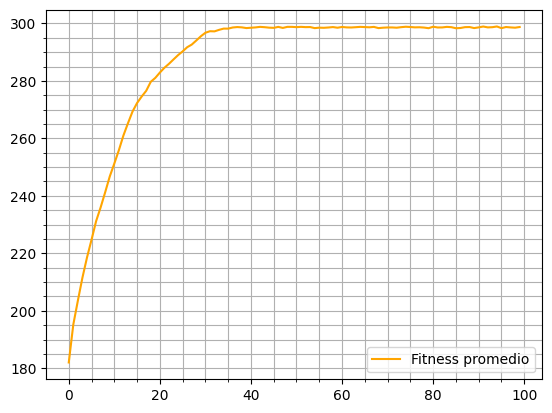

({'sabores': ['Naranja x',
   'Almendra',
   'Dulce de membrillo',
   'Sandía',
   'Yogur'],
  'bases': ['Fruta', 'Yogur', 'Leche de almendras'],
  'edulcorante': 'Maltitol',
  'toppings': ['Trozos de oreo', 'Pepitas de chocolate', 'Salsa de mango']},
 299.44)

In [ ]:
genetic_algorithm()

En esta gráfica podemos observar el fitness promedio del fitness de los individuos en cada generación.

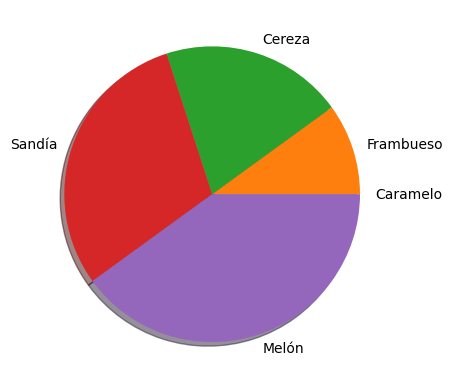

In [ ]:
ingredientes = ["Caramelo", "Frambueso", "Cereza", "Sandía", "Melón"]

plt.pie(np.arange(0, len(ingredientes)), labels=ingredientes, shadow=True)
plt.show()

In [ ]:
plt.pie?

Signature:
plt.pie(
    x: 'ArrayLike',
    explode: 'ArrayLike | None' = None,
    labels: 'Sequence[str] | None' = None,
    colors: 'ColorType | Sequence[ColorType] | None' = None,
    autopct: 'str | Callable[[float], str] | None' = None,
    pctdistance: 'float' = 0.6,
    shadow: 'bool' = False,
    labeldistance: 'float | None' = 1.1,
    startangle: 'float' = 0,
    radius: 'float' = 1,
    counterclock: 'bool' = True,
    wedgeprops: 'dict[str, Any] | None' = None,
    textprops: 'dict[str, Any] | None' = None,
    center: 'tuple[float, float]' = (0, 0),
    frame: 'bool' = False,
    rotatelabels: 'bool' = False,
    *,
    normalize: 'bool' = True,
    hatch: 'str | Sequence[str] | None' = None,
    data=None,
) -> 'tuple[list[Wedge], list[Text]] | tuple[list[Wedge], list[Text], list[Text]]'
Docstring:
Plot a pie chart.

Make a pie chart of array *x*.  The fractional area of each wedge is
given by ``x/sum(x)``.

The wedges are plotted counterclockwise, by default starting fr